## Data Analysis Notebook

This notebook combines data collection (scraping) and data preprocessing.

Steps:
1. **Scrape** reviews from Google Play Store
2. **Preprocess** and clean the data
3. **Visualize** the results

In [9]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# locate project root by searching upward for the 'scripts' folder
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "scripts").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent

# ensure project root is on sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("sys.path[0]:", sys.path[0])

# Try imports with fallbacks (case and location tolerant)
try:
    from scripts.preprocessing import ReviewPreprocessor
except Exception as e:
    try:
        from scripts.preprocessing import ReviewPreprocessor
    except Exception as e2:
        raise ImportError("Could not import ReviewPreprocessor (check scripts/preprocessing.py file and interpreter)") from e2

# Try scraper import with multiple filename cases
run_scraper = None
for modname in ("scripts.scraper", "scripts.Scraper", "scraper", "Scraper"):
    try:
        mod = __import__(modname, fromlist=["main"])
        run_scraper = getattr(mod, "main", None)
        if run_scraper:
            print(f"Imported run_scraper from {modname}")
            break
    except Exception:
        continue

if run_scraper is None:
    print("Warning: could not import run_scraper. Ensure scripts/Scraper.py or scripts/scraper.py exists.")

CORRECT_RAW_PATH = project_root / 'data' / 'raw'
CORRECT_PROCESSED_PATH = project_root / 'data' / 'processed'

print("\n📁 File paths configured:")
print(f"   • Raw data: {CORRECT_RAW_PATH}")
print(f"   • Processed data: {CORRECT_PROCESSED_PATH}")
print("💡 All future saves will go to the correct location!")


Project root: /home/avicci/Analytics_for_fintech_apps
sys.path[0]: /home/avicci/Analytics_for_fintech_apps
Imported run_scraper from scripts.scraper

📁 File paths configured:
   • Raw data: /home/avicci/Analytics_for_fintech_apps/data/raw
   • Processed data: /home/avicci/Analytics_for_fintech_apps/data/processed
💡 All future saves will go to the correct location!


## 1. Run Scraper

This cell runs the scraping script to fetch the latest reviews from the Google Play Store.
The output will show the progress.

In [2]:
print("🚀 Starting Scraper...")

# Run the main scraper function
raw_df = run_scraper()

print("\n✅ Scraping Finished.")
display(raw_df.head())

🚀 Starting Scraper...
Starting Google Play Store Review Scraper

[1/2] Fetching app information...

CBE: Commercial Bank of Ethiopia
App ID: com.combanketh.mobilebanking
Current Rating: 4.321017
Total Ratings: 38855
Total Reviews: 8336

BOA: Bank of Abyssinia
App ID: com.boa.boaMobileBanking
Current Rating: 4.201238
Total Ratings: 6333
Total Reviews: 1219

Dashen: Dashen Bank
App ID: com.dashen.dashensuperapp
Current Rating: 4.171717
Total Ratings: 3902
Total Reviews: 771

App information saved to data/raw/app_info.csv

[2/2] Scraping reviews...


Banks:   0%|          | 0/3 [00:00<?, ?it/s]


Scraping reviews for com.combanketh.mobilebanking (target=450)...
Successfully scraped 450 reviews
Collected 450 reviews for Commercial Bank of Ethiopia


Banks:  33%|███▎      | 1/3 [00:05<00:10,  5.22s/it]


Scraping reviews for com.boa.boaMobileBanking (target=450)...
Successfully scraped 450 reviews
Collected 450 reviews for Bank of Abyssinia


Banks:  67%|██████▋   | 2/3 [00:09<00:04,  4.61s/it]


Scraping reviews for com.dashen.dashensuperapp (target=450)...
Successfully scraped 450 reviews
Collected 450 reviews for Dashen Bank


Banks: 100%|██████████| 3/3 [00:13<00:00,  4.42s/it]


Scraping Complete!

Total reviews collected: 1350
Reviews per bank:
  Commercial Bank of Ethiopia: 450
  Bank of Abyssinia: 450
  Dashen Bank: 450

Data saved to: data/raw/reviews_raw.csv

Sample Reviews

Commercial Bank of Ethiopia:
------------------------------------------------------------

Rating: ⭐⭐⭐
Review: maaliif daddafee install gaafata...
Date: 2025-11-28 13:36:32

Rating: ⭐⭐⭐⭐⭐
Review: good app...
Date: 2025-11-28 11:33:17

Rating: ⭐⭐⭐⭐⭐
Review: This application is very important and advantage for transfer of money and finance in the coutry and foriegn country....
Date: 2025-11-27 23:08:20

Bank of Abyssinia:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: Very Good...
Date: 2025-11-28 20:18:20

Rating: ⭐⭐⭐⭐⭐
Review: goof...
Date: 2025-11-28 13:33:37

Rating: ⭐⭐⭐⭐⭐
Review: good!...
Date: 2025-11-28 12:19:31

Dashen Bank:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐
Review: It Is An Amazing app...
Date: 2025-

,review_id,review_text,rating,review_date,bank_code,bank_name,source
0,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28 13:36:32,CBE,Commercial Bank of Ethiopia,Google Play
1,ee0dbb0e-4eb0-47b5-9874-c37877493f99,good app,5,2025-11-28 11:33:17,CBE,Commercial Bank of Ethiopia,Google Play
2,5112423d-e618-44ba-ba49-62677cb76cd6,This application is very important and advanta...,5,2025-11-27 23:08:20,CBE,Commercial Bank of Ethiopia,Google Play
3,bcb34681-1dd4-4781-b400-4393bb10b1d9,why didn't work this app?,1,2025-11-27 22:40:35,CBE,Commercial Bank of Ethiopia,Google Play
4,c69f051a-00f8-4144-8423-b7ebcd328d2d,The app makes our life easier. Thank you CBE!,5,2025-11-27 18:00:06,CBE,Commercial Bank of Ethiopia,Google Play


## 2. Run Preprocessing Pipeline

Now we clean the scraped data using our `ReviewPreprocessor`.

In [3]:
# Initialize the preprocessor
preprocessor = ReviewPreprocessor()

# Run the process
success = preprocessor.process()

if success:
    print("\n✅ Preprocessing finished successfully!")
    df = preprocessor.df
else:
    print("❌ Preprocessing failed.")

STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1350 reviews from data/raw/reviews_raw.csv

[1/6] Checking for missing data...

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2024-08-28 to 2025-11-28

[4/6] Cleaning text...

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 1350 reviews

Saving processed data...
Data saved to: data/processed/reviews_processed.csv

PREPROCESSING REPORT
Original records: 1350
Records with missing critical data: 0
Empty reviews removed: 0
Invalid ratings removed: 0
Final records: 1350

Data retention rate: 100.00%
Data error rate: 0.00%

Reviews per bank:
  Bank of Abyssinia: 450
  Commercial Bank of Ethiopia: 450
  Dashen Bank: 450

Rating distribution:
  ⭐⭐⭐⭐⭐: 829 (61.4%)
  ⭐⭐⭐⭐: 99 (7.3%)
  ⭐⭐⭐: 73 (5.4%)
  ⭐⭐: 49 (3.6%)
  ⭐: 300 (22.2%)

Text statistics: avg=53, median=18

✅ Preprocessing finished successfully!


## 3. Visualizations

Let's explore the cleaned data with visualizations.

/tmp/ipykernel_1013/307724874.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')
/tmp/ipykernel_1013/307724874.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bank_code', data=df, palette='Set2')


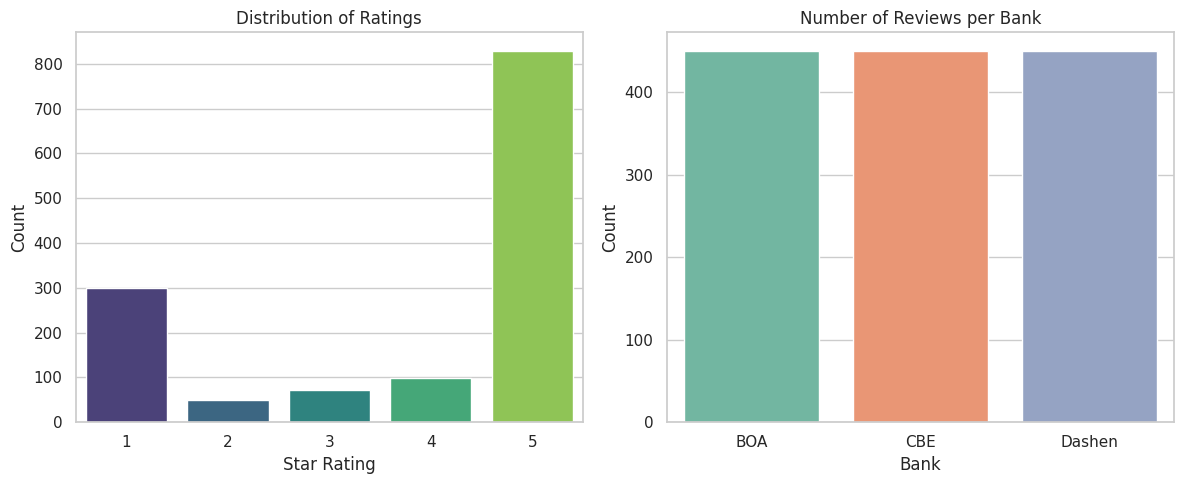

In [10]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# 1. Ratings Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')

# 2. Reviews per Bank
plt.subplot(1, 2, 2)
sns.countplot(x='bank_code', data=df, palette='Set2')
plt.title('Number of Reviews per Bank')
plt.xlabel('Bank')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

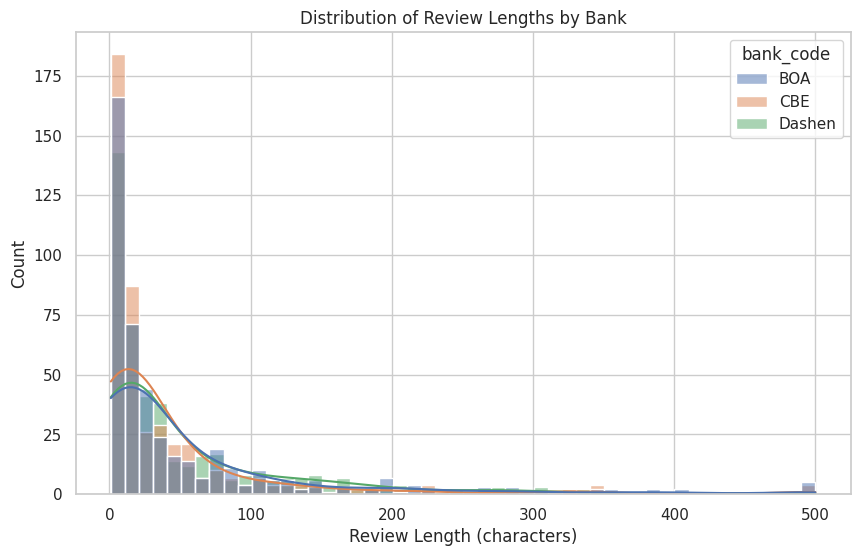

In [11]:
# 3. Review Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50, kde=True, hue='bank_code')
plt.title('Distribution of Review Lengths by Bank')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()

## Fixing file path problem

In [4]:
import os
import glob

print("📁 Current files in notebooks/data/:")
if os.path.exists('data'):
    for root, dirs, files in os.walk('data'):
        level = root.replace('data', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}📂 {os.path.basename(root)}/")
        for file in files:
            print(f"{indent}  📄 {file}")
else:
    print("No 'data' folder in notebooks/")

📁 Current files in notebooks/data/:
📂 data/
  📂 processed/
    📄 reviews_processed.csv
  📂 raw/
    📄 app_info.csv
    📄 reviews_raw.csv


In [6]:
import os
import shutil

print("🚚 Starting to move files...")

# Move files from notebooks/data/raw/ to ../data/raw/
source_raw = 'data/raw'
target_raw = '../data/raw'

if os.path.exists(source_raw):
    print(f"\n📂 Moving raw files from {source_raw} to {target_raw}")
    
    # No need to create directory - it already exists!
    
    # Move each file
    for file_name in os.listdir(source_raw):
        source_path = os.path.join(source_raw, file_name)
        target_path = os.path.join(target_raw, file_name)
        
        shutil.move(source_path, target_path)
        print(f"   ✅ Moved: {file_name}")
    
    # Remove empty source directory
    os.rmdir(source_raw)
    print("   🗑️ Removed empty raw directory")

# Move files from notebooks/data/processed/ to ../data/processed/
source_processed = 'data/processed'
target_processed = '../data/processed'

if os.path.exists(source_processed):
    print(f"\n📂 Moving processed files from {source_processed} to {target_processed}")
    
    # No need to create directory - it already exists!
    
    # Move each file
    for file_name in os.listdir(source_processed):
        source_path = os.path.join(source_processed, file_name)
        target_path = os.path.join(target_processed, file_name)
        
        shutil.move(source_path, target_path)
        print(f"   ✅ Moved: {file_name}")
    
    # Remove empty source directory
    os.rmdir(source_processed)
    print("   🗑️ Removed empty processed directory")

# Remove the main data directory if empty
if os.path.exists('data') and not os.listdir('data'):
    os.rmdir('data')
    print("\n🗑️ Removed empty main data directory")

print("\n🎉 All files moved successfully!")

🚚 Starting to move files...

📂 Moving raw files from data/raw to ../data/raw
   ✅ Moved: app_info.csv
   ✅ Moved: reviews_raw.csv
   🗑️ Removed empty raw directory

📂 Moving processed files from data/processed to ../data/processed
   ✅ Moved: reviews_processed.csv
   🗑️ Removed empty processed directory

🗑️ Removed empty main data directory

🎉 All files moved successfully!


In [7]:
print("🔍 Verifying files in new location...")

# Check the correct locations
correct_locations = {
    'Raw Files': '../data/raw',
    'Processed Files': '../data/processed'
}

for description, path in correct_locations.items():
    print(f"\n📂 {description} ({path}):")
    if os.path.exists(path):
        files = os.listdir(path)
        if files:
            for file in files:
                file_path = os.path.join(path, file)
                file_size = os.path.getsize(file_path)
                print(f"   ✅ {file} ({file_size} bytes)")
        else:
            print("   ❌ No files found")
    else:
        print("   ❌ Directory doesn't exist")

print("\n✅ Verification complete!")

🔍 Verifying files in new location...

📂 Raw Files (../data/raw):
   ✅ app_info.csv (364 bytes)
   ✅ reviews_raw.csv (205747 bytes)

📂 Processed Files (../data/processed):
   ✅ reviews_processed.csv (223627 bytes)

✅ Verification complete!
